In [1]:
# import os
# os.environ['KERAS_BACKEND'] = 'plaidml.keras.backend'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras

In [3]:
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

import keras.backend as K

In [4]:
import tensorflow as tf

Original source of the dataset:

http://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_csv("/content/drive/MyDrive/Portfolio Data Enthusiast/MultiVariate-RNN-with-TensorFlow-and-Keras-master/MultiVariate-RNN-with-TensorFlow-and-Keras-master/DATA/energydata_complete.csv", index_col='date',
                 infer_datetime_format=True)

In [7]:
df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 non-null  float64
 18  T9           19735 

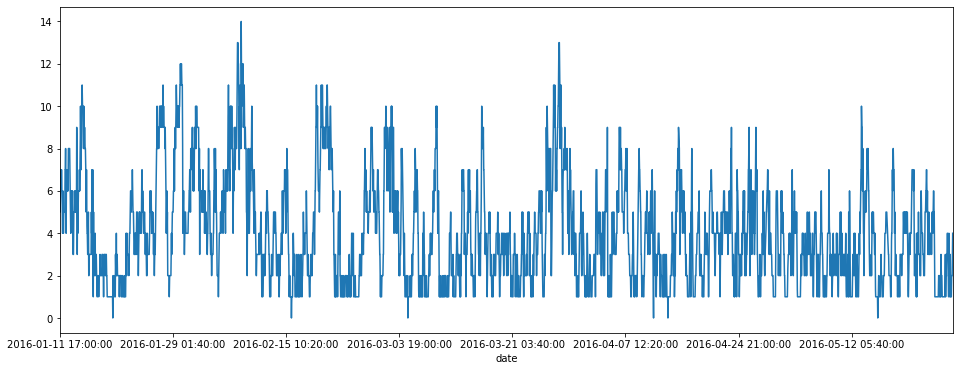

In [9]:
ax = df['Windspeed'].plot(figsize=(16, 6))
ax.autoscale(axis='x', tight=True)

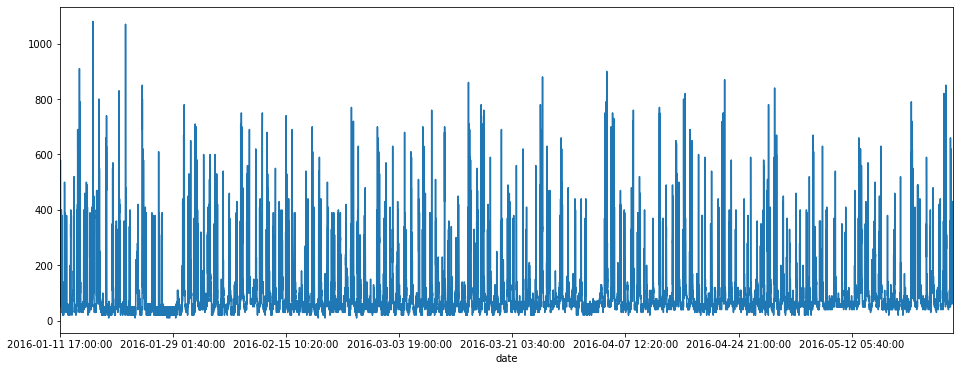

In [10]:
ax = df['Appliances'].plot(figsize=(16, 6))
ax.autoscale(axis='x', tight=True)

## train test split

In [11]:
len(df)

19735

In [12]:
df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [13]:
df.tail()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,45.590000,23.20,52.400000,24.796667,1.0,24.500000,44.500000,24.7000,50.07400,23.2,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,45.590000,23.23,52.326667,24.196667,1.0,24.557143,44.414286,24.7000,49.79000,23.2,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,45.730000,23.23,52.266667,23.626667,1.0,24.540000,44.400000,24.7000,49.66000,23.2,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,45.790000,23.20,52.200000,22.433333,1.0,24.500000,44.295714,24.6625,49.51875,23.2,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784
2016-05-27 18:00:00,430,10,25.500000,46.600000,25.264286,42.971429,26.823333,41.156667,24.7,45.963333,23.20,52.200000,21.026667,1.0,24.500000,44.054000,24.7360,49.73600,23.2,46.8450,22.200000,755.2,57.000000,4.000000,27.000000,13.200000,34.118851,34.118851


Dari sini ada beberapa hal yang perlu diperhatikan:
1. Kita tidak akan menggunakan seluruh data, kita hanya akan menggunakan data kurang lebih 1 bulan terakhir.
2. Kita perlu membulatkan nilai decimal (mengurangi angka dibelakang koma). Presisi, banyaknya angka di belakang koma mungkin akan mengakibatkan masalah pada network (deep learning model) kita.

In [14]:
new_df = df.loc['2016-05-01':]

In [15]:
new_df = new_df.round(2)

In [16]:
new_df

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-05-01 00:00:00,50,0,21.20,38.20,18.39,41.40,23.20,36.40,19.73,37.73,19.50,47.29,4.80,40.06,19.50,31.60,22.20,40.00,19.17,38.20,4.30,763.70,86.00,2.00,40.00,2.20,15.31,15.31
2016-05-01 00:10:00,60,0,21.15,38.17,18.39,41.50,23.13,36.47,19.70,37.66,19.50,47.29,4.80,40.09,19.50,31.60,22.20,40.40,19.13,38.29,4.28,763.72,86.33,2.17,38.17,2.22,11.24,11.24
2016-05-01 00:20:00,50,0,21.13,38.09,18.32,41.50,23.20,36.50,19.70,37.59,19.50,47.26,4.66,40.03,19.50,31.60,22.20,41.00,19.13,38.36,4.27,763.73,86.67,2.33,36.33,2.23,21.81,21.81
2016-05-01 00:30:00,50,0,21.10,38.09,18.29,41.50,23.20,36.50,19.70,37.50,19.50,47.26,4.53,41.30,19.50,31.60,22.20,41.33,19.17,38.50,4.25,763.75,87.00,2.50,34.50,2.25,47.00,47.00
2016-05-01 00:40:00,60,0,21.10,38.03,18.29,41.56,23.20,36.50,19.70,37.50,19.50,47.20,4.59,41.83,19.50,31.60,22.20,41.63,19.17,38.63,4.23,763.77,87.33,2.67,32.67,2.27,8.06,8.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-27 17:20:00,100,0,25.57,46.56,25.89,42.03,27.20,41.16,24.70,45.59,23.20,52.40,24.80,1.00,24.50,44.50,24.70,50.07,23.20,46.79,22.73,755.20,55.67,3.33,23.67,13.33,43.10,43.10
2016-05-27 17:30:00,90,0,25.50,46.50,25.75,42.08,27.13,41.22,24.70,45.59,23.23,52.33,24.20,1.00,24.56,44.41,24.70,49.79,23.20,46.79,22.60,755.20,56.00,3.50,24.50,13.30,49.28,49.28
2016-05-27 17:40:00,270,10,25.50,46.60,25.63,42.77,27.05,41.69,24.70,45.73,23.23,52.27,23.63,1.00,24.54,44.40,24.70,49.66,23.20,46.79,22.47,755.20,56.33,3.67,25.33,13.27,29.20,29.20


In [17]:
# How many rows for a day
24 * 60 / 10

144.0

In [18]:
# set test range time to 2 days
test_idx = 2 * 144

In [19]:
train = new_df.iloc[:-test_idx]
test = new_df.iloc[-test_idx:]

In [20]:
test

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-05-25 18:10:00,170,0,24.50,37.86,24.00,34.27,25.00,36.70,24.29,37.79,21.20,51.37,19.32,1.00,23.29,34.70,24.39,39.13,22.00,37.23,16.48,756.1,55.83,2.00,38.17,7.62,38.14,38.14
2016-05-25 18:20:00,310,0,24.50,37.30,23.86,34.33,24.94,36.67,24.29,37.79,21.29,51.14,19.39,1.00,23.32,34.76,24.41,39.62,22.00,37.36,16.47,756.1,55.67,2.00,36.33,7.53,31.16,31.16
2016-05-25 18:30:00,120,0,24.50,36.96,23.73,34.33,24.85,36.50,24.29,37.79,21.32,50.73,19.43,1.00,23.36,34.94,24.50,40.34,22.03,37.39,16.45,756.1,55.50,2.00,34.50,7.45,4.40,4.40
2016-05-25 18:40:00,120,0,24.50,37.00,23.70,34.40,24.84,36.45,24.29,37.90,21.39,50.35,19.36,1.00,23.39,35.00,24.55,40.54,22.10,37.72,16.43,756.1,55.33,2.00,32.67,7.37,27.12,27.12
2016-05-25 18:50:00,120,0,24.49,37.07,23.68,34.52,24.84,36.49,24.28,37.93,21.39,50.35,19.25,1.66,23.39,35.05,24.54,40.59,22.10,37.81,16.42,756.1,55.17,2.00,30.83,7.28,10.27,10.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-27 17:20:00,100,0,25.57,46.56,25.89,42.03,27.20,41.16,24.70,45.59,23.20,52.40,24.80,1.00,24.50,44.50,24.70,50.07,23.20,46.79,22.73,755.2,55.67,3.33,23.67,13.33,43.10,43.10
2016-05-27 17:30:00,90,0,25.50,46.50,25.75,42.08,27.13,41.22,24.70,45.59,23.23,52.33,24.20,1.00,24.56,44.41,24.70,49.79,23.20,46.79,22.60,755.2,56.00,3.50,24.50,13.30,49.28,49.28
2016-05-27 17:40:00,270,10,25.50,46.60,25.63,42.77,27.05,41.69,24.70,45.73,23.23,52.27,23.63,1.00,24.54,44.40,24.70,49.66,23.20,46.79,22.47,755.2,56.33,3.67,25.33,13.27,29.20,29.20


## scale data

In [21]:
scaler = MinMaxScaler()

In [22]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [23]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

## time series generator

In [24]:
length = 144
batch = 1
train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch)

In [25]:
scaled_train.shape

(3565, 28)

In [26]:
len(scaled_train)

3565

In [27]:
len(train_generator)

3421

In [28]:
X, y = train_generator[0]

In [29]:
print(f"given the array: \n{X}")
print(f"predict this y: \n{y}")

given the array: 
[[[0.03896104 0.         0.13798978 ... 0.21301775 0.30618371 0.30618371]
  [0.05194805 0.         0.12947189 ... 0.21420118 0.22473484 0.22473484]
  [0.03896104 0.         0.12606474 ... 0.2147929  0.43626176 0.43626176]
  ...
  [0.05194805 0.         0.32367973 ... 0.15680473 0.43406044 0.43406044]
  [0.05194805 0.         0.30834753 ... 0.14970414 0.64078447 0.64078447]
  [0.03896104 0.         0.30834753 ... 0.14319527 0.75185111 0.75185111]]]
predict this y: 
[[0.03896104 0.         0.30834753 0.29439421 0.16038492 0.49182278
  0.0140056  0.36627907 0.24142857 0.24364791 0.12650602 0.36276002
  0.12       0.28205572 0.06169297 0.15759185 0.34582624 0.39585974
  0.09259259 0.39649608 0.18852459 0.96052632 0.59210526 0.1
  0.58333333 0.13609467 0.4576746  0.4576746 ]]


## build the model

In [30]:
model = Sequential()
model.add(LSTM(36, input_shape=(length, scaled_train.shape[1])))
model.add(Dense(scaled_train.shape[1]))

model.compile(optimizer='adam', loss='mse')

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 36)                9360      
_________________________________________________________________
dense (Dense)                (None, 28)                1036      
Total params: 10,396
Trainable params: 10,396
Non-trainable params: 0
_________________________________________________________________


## early stopping

In [32]:
early_stop = EarlyStopping(monitor='val_loss', patience=1)
val_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=batch)

In [33]:
# K._make_rng_state(seed=101)
tf.random.set_seed(101)

model.fit_generator(train_generator, epochs=10,
                    validation_data=val_generator,
                    callbacks=[early_stop])

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


3421/3421 [==============================] - 166s 48ms/step - loss: 0.0273 - val_loss: 0.0132
Epoch 2/10
3421/3421 [==============================] - 162s 47ms/step - loss: 0.0089 - val_loss: 0.0103
Epoch 3/10
3421/3421 [==============================] - 164s 48ms/step - loss: 0.0080 - val_loss: 0.0097
Epoch 4/10
3421/3421 [==============================] - 163s 48ms/step - loss: 0.0076 - val_loss: 0.0088
Epoch 5/10
3421/3421 [==============================] - 166s 49ms/step - loss: 0.0073 - val_loss: 0.0082
Epoch 6/10
3421/3421 [==============================] - 165s 48ms/step - loss: 0.0074 - val_loss: 0.0080
Epoch 7/10
3421/3421 [==============================] - 165s 48ms/step - loss: 0.0072 - val_loss: 0.0084


In [34]:
model.save('/content/drive/MyDrive/Portfolio Data Enthusiast/MultiVariate-RNN-with-TensorFlow-and-Keras-master/MultiVariate-RNN-with-TensorFlow-and-Keras-master/multivariate.h5')

In [35]:
# load saved model
# from keras.models import load_model

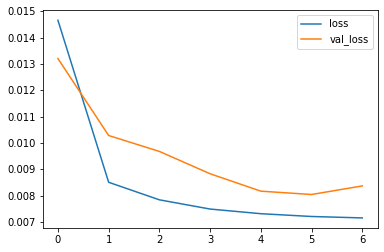

In [36]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [39]:
first_eval_batch = scaled_train[-length:]
first_eval_batch

array([[0.1038961 , 0.        , 0.72231687, ..., 0.53550296, 0.15909546,
        0.15909546],
       [0.11688312, 0.        , 0.73424191, ..., 0.52662722, 0.40344207,
        0.40344207],
       [0.11688312, 0.        , 0.73424191, ..., 0.51775148, 0.20452271,
        0.20452271],
       ...,
       [0.18181818, 0.        , 0.70017036, ..., 0.50118343, 0.33340004,
        0.33340004],
       [0.09090909, 0.        , 0.70017036, ..., 0.51952663, 0.78747248,
        0.78747248],
       [0.1038961 , 0.        , 0.70017036, ..., 0.53846154, 0.77286372,
        0.77286372]])

In [40]:
# reshaping
first_eval_batch = first_eval_batch.reshape((1, length, scaled_train.shape[1]))

In [41]:
model.predict(first_eval_batch)

array([[0.0731081 , 0.06492437, 0.69998974, 0.39750332, 0.54273784,
        0.42516202, 0.4298571 , 0.44528311, 0.69841623, 0.39410904,
        0.30140808, 0.38818923, 0.6413259 , 0.02186681, 0.62749416,
        0.40045106, 0.53364986, 0.31767374, 0.53564054, 0.35370713,
        0.59312904, 0.52929467, 0.44429883, 0.20585226, 0.5855548 ,
        0.53862906, 0.48719102, 0.49077904]], dtype=float32)

In [42]:
scaled_test[0]

array([0.19480519, 0.        , 0.70017036, 0.3920434 , 0.53007217,
       0.41064526, 0.40616246, 0.41913319, 0.72714286, 0.4115245 ,
       0.30722892, 0.36445121, 0.66777778, 0.        , 0.61119082,
       0.39840637, 0.51618399, 0.32953105, 0.53703704, 0.34024896,
       0.6057377 , 0.52631579, 0.41881579, 0.2       , 0.55283333,
       0.53372781, 0.76305783, 0.76305783])

In [43]:
n_features = scaled_train.shape[1]
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [44]:
true_predictions = scaler.inverse_transform(test_predictions)

In [45]:
true_predictions

array([[ 76.29323654,   1.94773123,  24.49893975, ...,   7.70283103,
         24.35493534,  24.53422874],
       [ 60.71912628,   2.59505734,  24.44513322, ...,   7.70586507,
         24.57713025,  25.05578409],
       [ 54.42935266,   2.85828866,  24.39232979, ...,   7.73726923,
         24.80006083,  25.24234489],
       ...,
       [-12.6055944 ,  -2.22062275,  26.67608622, ...,  13.13873061,
         31.19628145,  30.45684398],
       [-12.60551408,  -2.22062275,  26.67608692, ...,  13.13873061,
         31.19628443,  30.45684101],
       [-12.60550261,  -2.22062275,  26.67608762, ...,  13.13873262,
         31.19628741,  30.45684101]])

In [46]:
true_predictions = pd.DataFrame(data=true_predictions,columns=test.columns)

In [47]:
true_predictions

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,76.293237,1.947731,24.498940,38.010967,24.157941,34.758199,25.169180,37.194757,24.088914,37.406163,21.161350,52.773629,18.605799,2.263683,23.403634,34.746190,24.492525,38.849337,21.992459,37.521908,16.172349,756.167918,57.766711,2.058523,40.133287,7.702831,24.354935,24.534229
1,60.719126,2.595057,24.445133,37.998997,24.089130,34.955844,25.236335,37.423396,24.003581,37.293684,21.198930,53.952081,17.940436,4.286426,23.396687,34.937649,24.572200,39.012099,21.966093,37.753987,15.911366,756.220564,59.218715,2.142036,40.304905,7.705865,24.577130,25.055784
2,54.429353,2.858289,24.392330,37.951170,23.981835,35.128064,25.277939,37.633168,23.930049,37.246544,21.218442,55.100772,17.245137,6.421051,23.383044,35.134813,24.646416,39.236837,21.948786,37.963193,15.599834,756.300509,60.689469,2.193302,40.526981,7.737269,24.800061,25.242345
3,51.251761,2.904573,24.342423,37.956961,23.849352,35.341505,25.316596,37.802996,23.871250,37.232437,21.232186,56.107763,16.568342,8.648617,23.364218,35.314595,24.718844,39.487195,21.941101,38.166071,15.275526,756.361934,62.231173,2.223171,40.821052,7.771987,24.909405,25.336773
4,49.174395,2.833998,24.297303,37.999237,23.700544,35.605683,25.356766,37.954612,23.824246,37.254883,21.244546,57.010568,15.912208,10.973708,23.347569,35.485947,24.790631,39.755728,21.940957,38.370408,14.943222,756.427579,63.844289,2.236996,41.162490,7.810816,24.986368,25.408319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,-12.605549,-2.220623,26.676085,50.406679,13.585801,68.762538,30.946545,45.617878,25.755147,52.553550,23.891510,59.186593,-9.670238,114.800000,26.986385,39.837875,27.898505,64.507300,27.632988,48.886220,1.134398,750.072511,144.222144,4.628191,68.532412,13.138731,31.196281,30.456841
284,-12.605526,-2.220624,26.676086,50.406678,13.585801,68.762542,30.946545,45.617878,25.755147,52.553552,23.891510,59.186600,-9.670238,114.800000,26.986387,39.837875,27.898505,64.507300,27.632988,48.886219,1.134397,750.072508,144.222153,4.628192,68.532419,13.138731,31.196281,30.456841
285,-12.605594,-2.220623,26.676086,50.406679,13.585800,68.762538,30.946546,45.617878,25.755147,52.553552,23.891510,59.186603,-9.670240,114.799993,26.986387,39.837878,27.898505,64.507297,27.632988,48.886219,1.134397,750.072504,144.222144,4.628192,68.532419,13.138731,31.196281,30.456844
286,-12.605514,-2.220623,26.676087,50.406678,13.585801,68.762534,30.946547,45.617877,25.755147,52.553552,23.891510,59.186603,-9.670241,114.800000,26.986389,39.837881,27.898504,64.507297,27.632989,48.886219,1.134397,750.072504,144.222162,4.628192,68.532434,13.138731,31.196284,30.456841
